In [2]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import random 

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = self.load_images()

    def load_images(self):
        images = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
input_dir = '../input'
path_to_train = os.path.join(input_dir, 'asl-alphabet', 'asl_alphabet_train', 'asl_alphabet_train')
path_to_test = os.path.join(input_dir, 'asl-alphabet-test', 'asl-alphabet-test')

In [5]:
####### attempt with CustomDataset #######

train_dataset = CustomDataset(path_to_train, transform=transforms.Compose([
    transforms.RandomRotation(degrees=5),             
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02), 
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

test_dataset = CustomDataset(path_to_test, transform=transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [6]:
inceptionv3_model = models.inception_v3(pretrained=True)


num_classes = len(train_dataset.classes)
inceptionv3_model.fc = nn.Linear(inceptionv3_model.fc.in_features, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(inceptionv3_model.parameters(), lr=0.0001)

D:\softwares\Anaconda3\envs\CS766\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\softwares\Anaconda3\envs\CS766\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\qilin/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
22.5%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable


In [7]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
inceptionv3_model.to(device)

num_iters = 1000
iter_counter = 0
iter = [0]
test_accuracy = [0]
train_accuracy = [0]
epoch_counter = 0
while iter_counter < num_iters:
    inceptionv3_model.train()
    running_loss = 0.0
    total_samples = 0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        if iter_counter >= num_iters:
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = inceptionv3_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        
        #### Cathy added #####
        _, predicted_train = torch.max(outputs, 1)
        correct_train += (predicted_train == labels).sum().item()
        total_train += labels.size(0)
        ######################

        iter_counter += 1
        
        if ((iter_counter+1) % 50 == 0):
            train_acc = correct_train / total_train * 100
            train_accuracy.append(train_acc)
            
            print(f"Iteration {iter_counter+1}/{num_iters}, Training Loss: {running_loss/total_samples:.4f}, Training Accuracy: {correct_train / total_train * 100:.2f}%")
            running_loss = 0.0
      
            inceptionv3_model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = inceptionv3_model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            

            print(f"Iteration {iter_counter+1}/{num_iters}, Testing Accuracy: {(correct/total)*100:.2f}%")
            iter.append(iter_counter+1)
            test_accuracy.append((correct/total)*100)
            running_loss = 0.0
            total_samples = 0
            inceptionv3_model.train()

torch.save(inceptionv3_model.state_dict(), 'fine_tuned_inceptionv3.pth')

using cuda
Iteration 50/1000, Training Loss: 2.7276, Training Accuracy: 36.67%
Iteration 50/1000, Testing Accuracy: 35.98%


KeyboardInterrupt: 

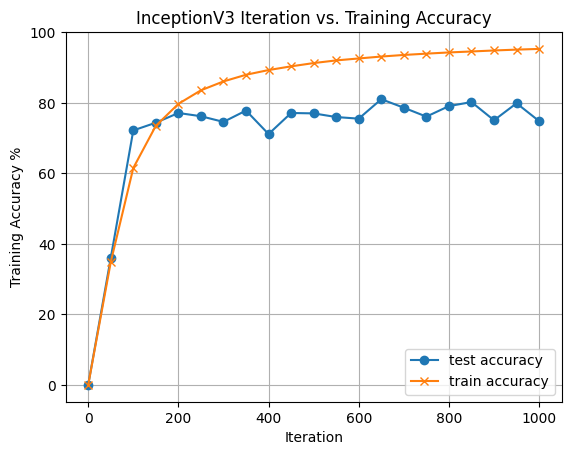

In [5]:
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy %")
plt.title("InceptionV3 Iteration vs. Training Accuracy")
plt.plot(iter, test_accuracy, marker='o')
plt.plot(iter, train_accuracy, marker='x')
plt.legend(['test accuracy', 'train accuracy']) 
plt.grid()

plt.savefig("withaug.png")
plt.show()

In [6]:
len(test_accuracy), len(train_accuracy)

(21, 21)

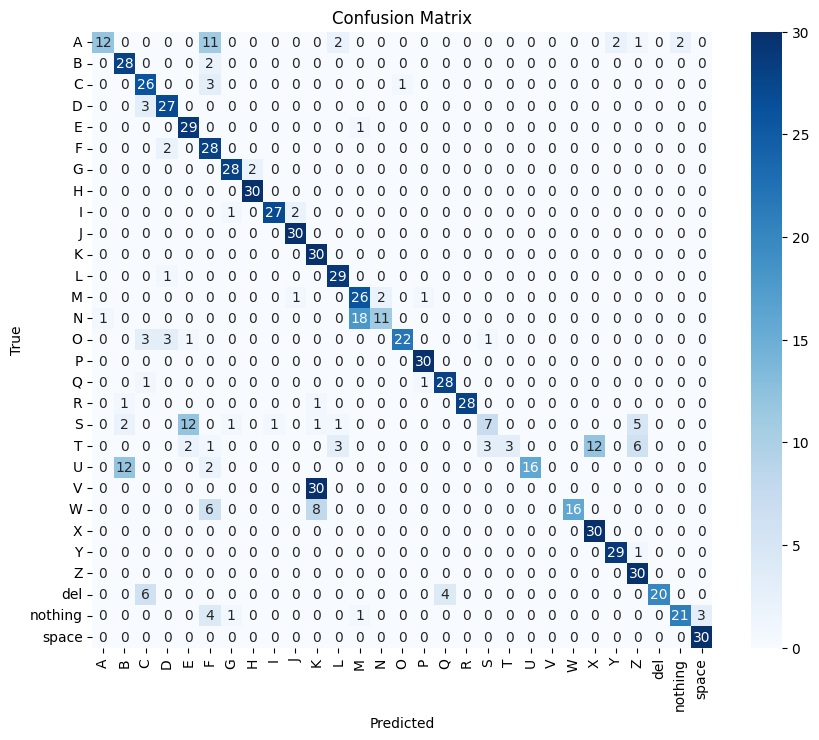

In [9]:
inceptionv3_model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = inceptionv3_model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy()) 
        true_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inceptionv3_model.load_state_dict(torch.load('fine_tuned_inceptionv3.pth',map_location=device))
inceptionv3_model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

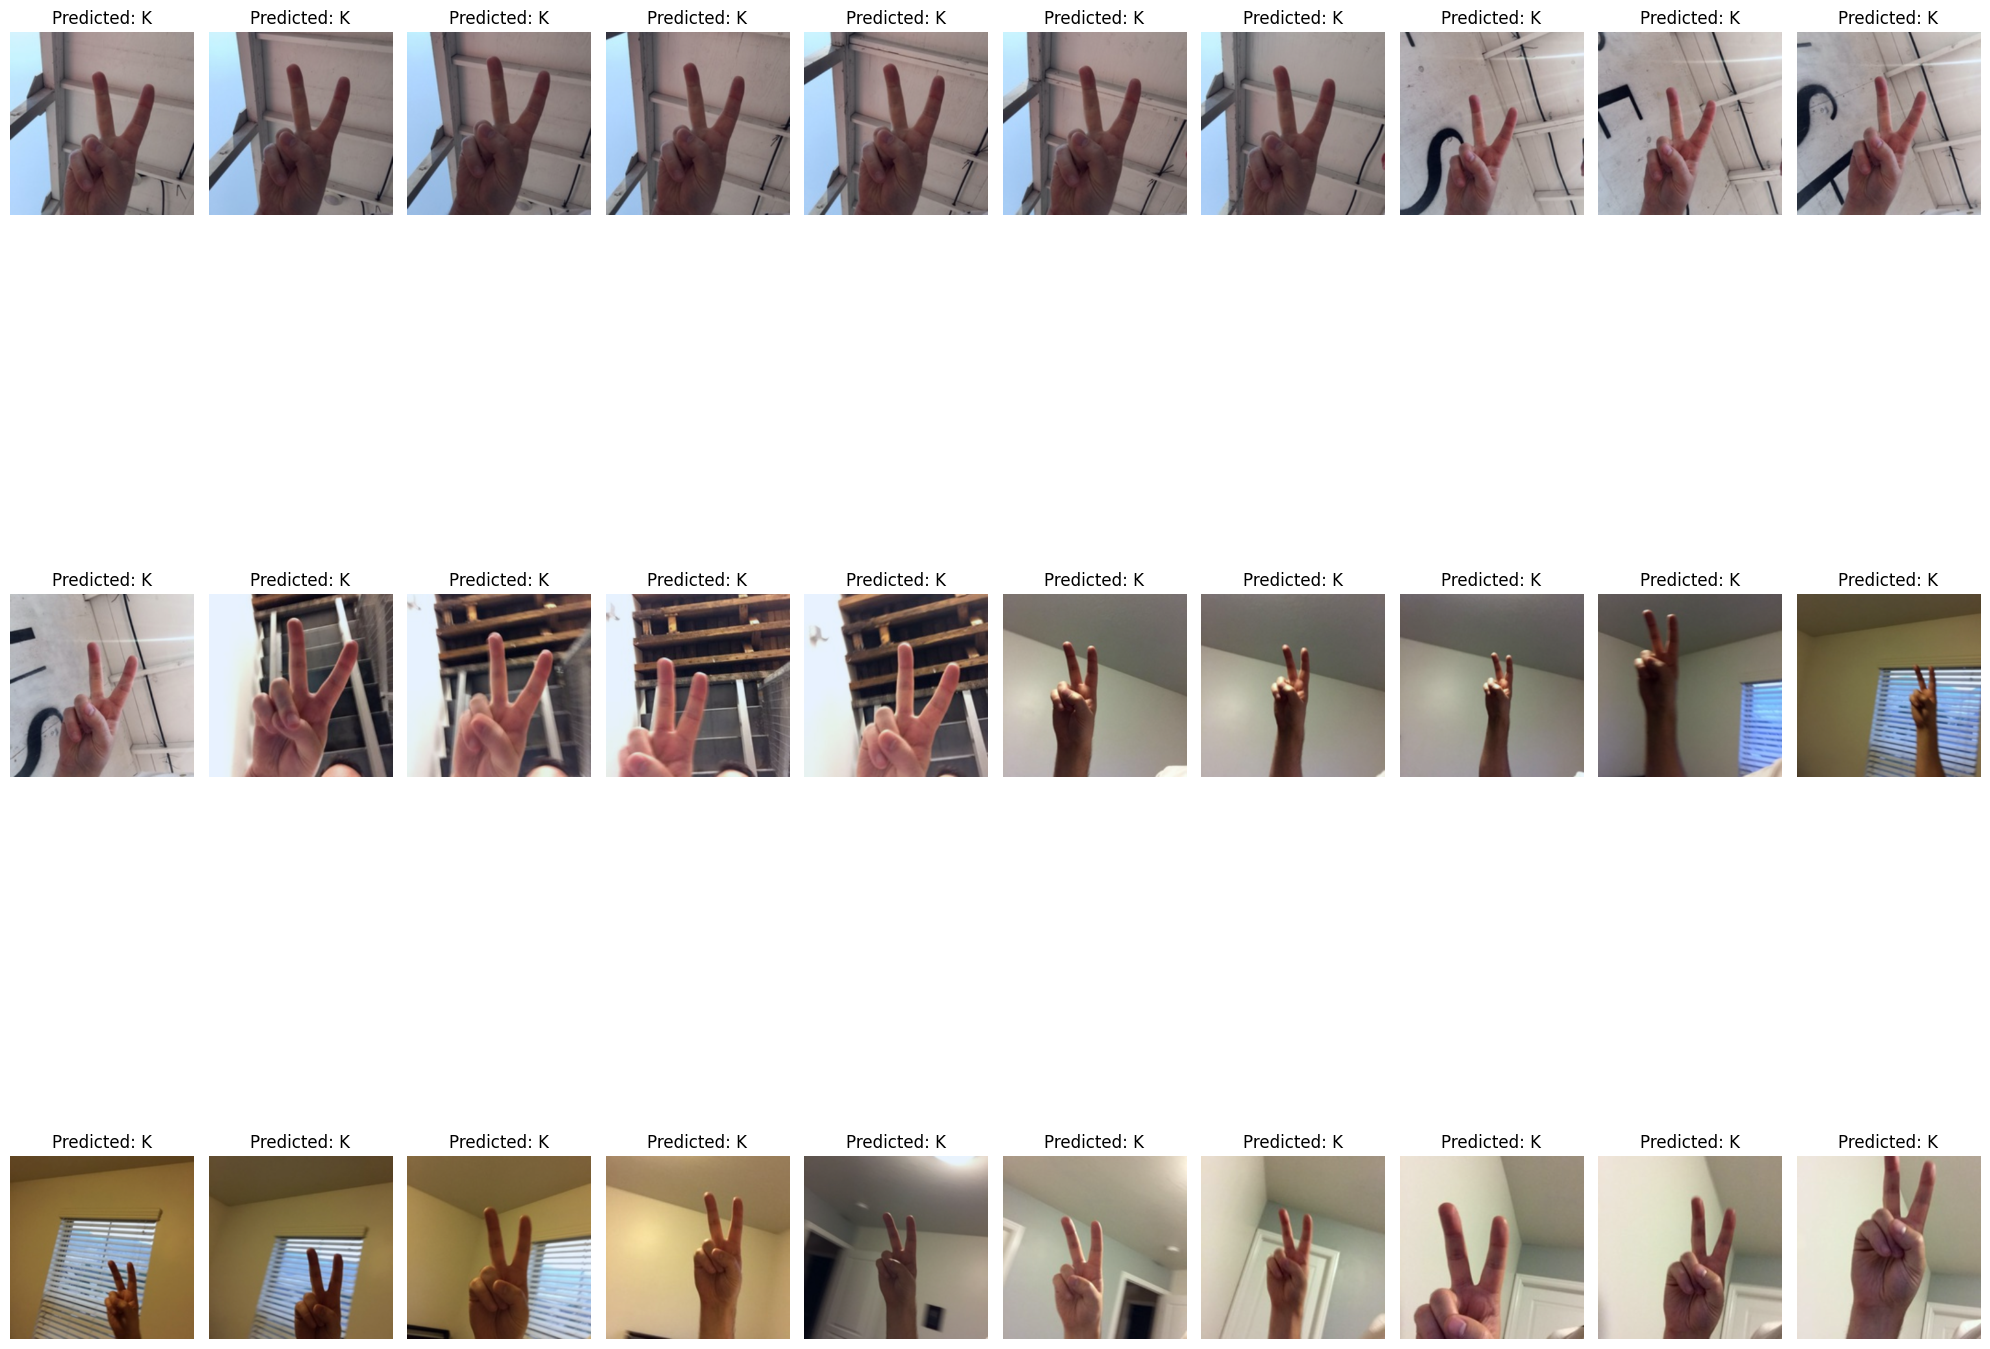

In [10]:
inceptionv3_model.eval()

v_images = []
v_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = inceptionv3_model(inputs)
        _, predicted = torch.max(outputs, 1)
        v_images.extend(inputs[labels == test_dataset.classes.index("V")].cpu().numpy())
        v_labels.extend(predicted[labels == test_dataset.classes.index("V")].cpu().numpy())

fig, axes = plt.subplots(3, 10, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    img = np.transpose(v_images[i], (1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax.imshow(img)
    ax.set_title(f"Predicted: {test_dataset.classes[v_labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

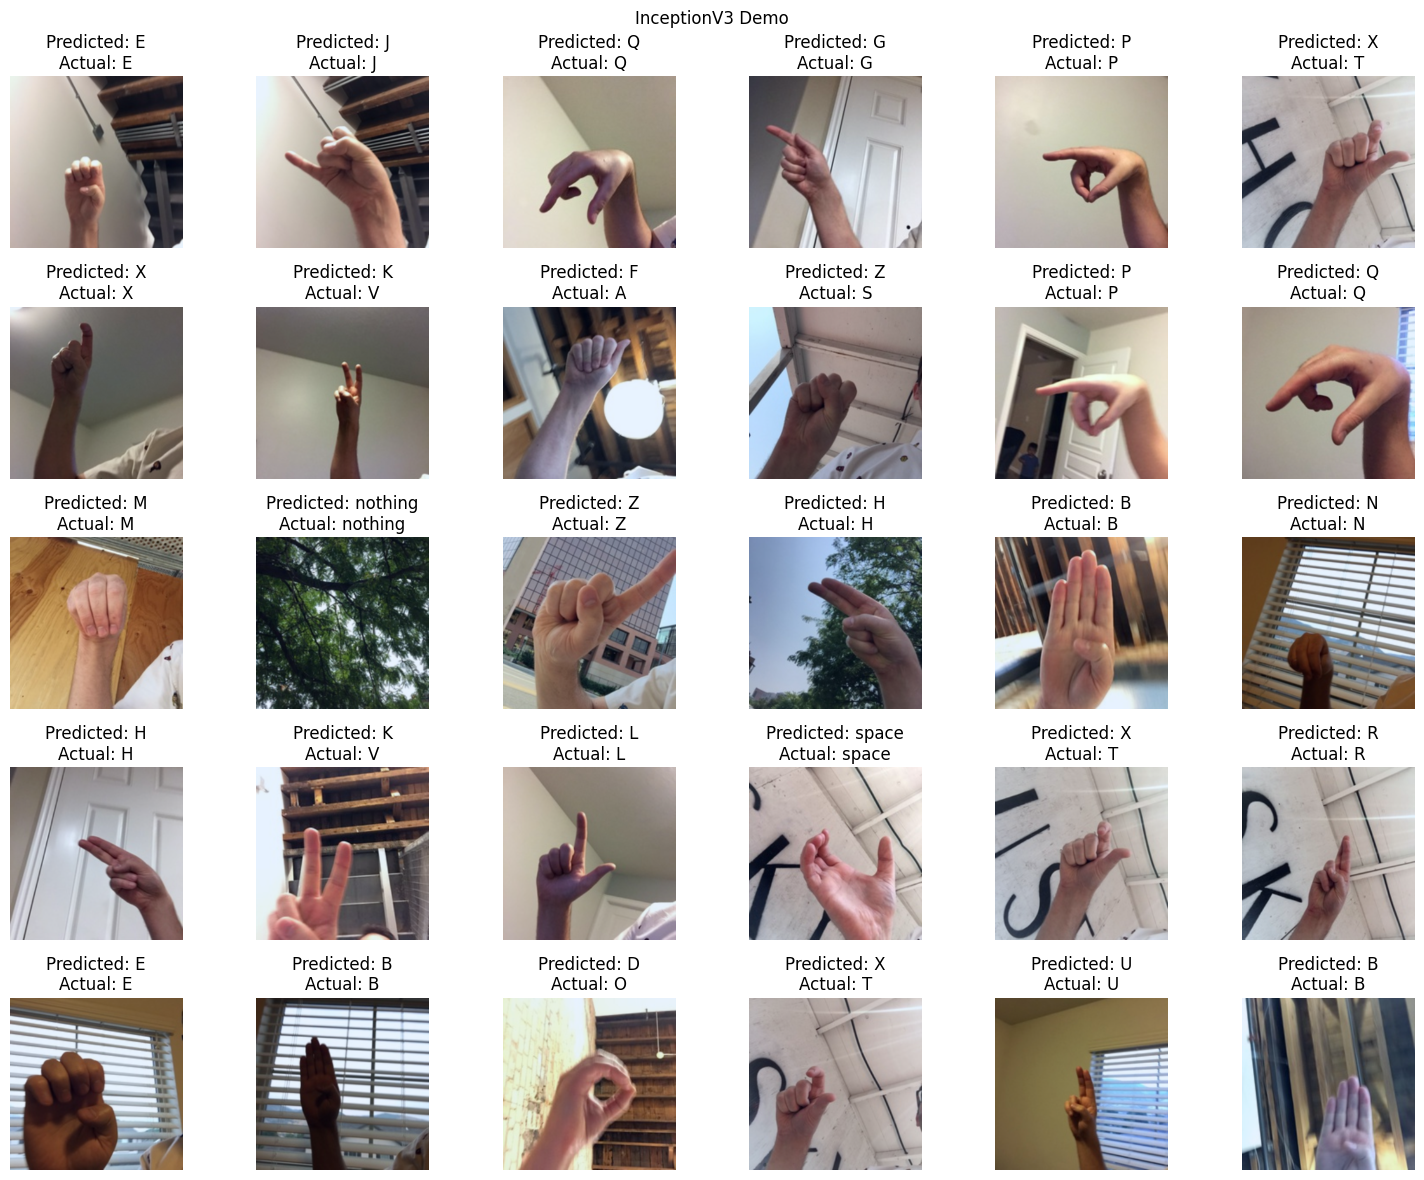

In [17]:
inceptionv3_model.eval()
random_indices = random.sample(range(len(test_dataset)), 30)
sampled_images = []
predicted_labels = []
actual_labels = []

with torch.no_grad():
    for i in random_indices:
        input, label = test_dataset[i]
        input = input.to(device).unsqueeze(0)         
        output = inceptionv3_model(input)
        _, predicted = torch.max(output, 1)
        sampled_images.append(input.cpu().squeeze(0))  
        predicted_labels.append(predicted.item())
        actual_labels.append(label)

fig, axes = plt.subplots(5, 6, figsize=(15, 12))  
axes = axes.ravel()

for i, ax in enumerate(axes):
    img = np.transpose(sampled_images[i].cpu().numpy(), (1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    ax.imshow(img)
    ax.set_title(f'Predicted: {test_dataset.classes[predicted_labels[i]]}\nActual: {test_dataset.classes[actual_labels[i]]}')
    ax.axis('off')

fig.suptitle("InceptionV3 Demo")
plt.tight_layout()
plt.show()